In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=''
import tensorflow as tf
import numpy as np
import numpy.random as rng
from data_loader.data_generator import MNISTDataGenerator, LinearDataGenerator
from models.npmodels import NPModel4,DirectNPModel4,AENPModel,AEDFANPModel
from trainers.sf_trainer import SFTrainer, AESFTrainer
from utils.config import process_config
import shutil
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go

import pickle
import itertools
from utils.utils import tf_matmul_r, tf_matmul_l, tf_eigvecs, tf_eigvals


In [2]:
inshape=30
hidden=20
outshape=10
batch_size=50
T = rng.randn(outshape, inshape)
def traindata(T, batch_size):
    train_x = rng.randn( batch_size,T.shape[1])
    train_y = np.dot( train_x,T.T)
    return (train_x, train_y)

In [3]:
#p = self.config.state_size[0]
p=30# inshape 
m =20# hiddenshap
j = 10#outshpae
#n = 10
var_xi = 0.1
# learning_rate=0
# lmda_learning_rate=1e-5
#lmda_learning_rate=0

#Training data inputs
x=tf.placeholder(tf.float32,[None,p], name = 'x')
y=tf.placeholder(tf.float32,[None,j], name = 'y')
learning_rate=tf.placeholder(tf.float32,[None],name='learning_rate')
lmda_learning_rate=tf.placeholder(tf.float32,[None],name='lmda_learning_rate')

#Scale weight initialization
alpha0 = np.sqrt(2.0/p)
alpha1 = np.sqrt(2.0/m)
alpha2 = np.sqrt(2.0/j)
alpha3 = 1

A = tf.Variable(rng.randn(p+1,m)*alpha0, name="hidden_weights", dtype=tf.float32)
W = tf.Variable(rng.randn(m+1,j)*alpha1, name="output_weights", dtype=tf.float32)
B = tf.Variable(rng.randn(m+1,j)*alpha2, name="feedback_weights", dtype=tf.float32)

# network architecture with ones added for bias terms
e0 = tf.ones([batch_size, 1], tf.float32)
e1 = tf.ones([batch_size, 1], tf.float32)
x_aug = tf.concat([x, e0], 1)
h = tf.sigmoid(tf.matmul(x_aug, A))
#Make some noise
h_aug = tf.concat([h, e1], 1)
xi = tf.random_normal(shape=tf.shape(h_aug), mean=0.0, stddev=var_xi, dtype=tf.float32)
h_tilde = h_aug + xi
#Add noise to hidden layer
y_p = tf.matmul(h_tilde, W)
y_p_0 = tf.matmul(h_aug, W)

trainable = [A, W, B]


In [4]:
#mean squared error
loss = tf.reduce_sum(tf.pow(y_p-y, 2))/2
loss_0 = tf.reduce_sum(tf.pow(y_p_0-y, 2))/2
e = (y_p - y)
h_prime = tf.multiply(h_tilde, 1-h_tilde)[:,0:m]

#Feedback data for saving
#Only take first item in epoch
delta_bp = tf.matmul(e, tf.transpose(W[0:m,:]))[0,:]
delta_fa = tf.matmul(e, tf.transpose(B[0:m,:]))[0,:]
norm_W = tf.norm(W)
norm_B = tf.norm(B)
error_FA = tf.norm(delta_bp - delta_fa)
alignment = tf.reduce_sum(tf.multiply(delta_fa,delta_bp))/tf.norm(delta_fa)/tf.norm(delta_bp)
norm_diff = tf.norm(W - B)
eigs = tf_eigvals(tf.matmul(tf.transpose(B), W))

#Compute updates for W and A (based on B)
lmda = tf.matmul(e, tf.transpose(B[0:m,:]))
grad_W = tf.gradients(xs=W, ys=loss)[0]
grad_A = tf.matmul(tf.transpose(x_aug), tf.multiply(h_prime, lmda))
grad_B = tf.matmul(tf.matmul(B, tf.transpose(e)) - tf.transpose(xi)*(loss - loss_0)/var_xi, e)

new_W = W.assign(W - learning_rate*grad_W)
new_A = A.assign(A - learning_rate*grad_A)            
new_B = B.assign(B - lmda_learning_rate*grad_B)
train_step = [new_W, new_A, new_B]


# correct_prediction = tf.equal(tf.argmax(y_p, 1), tf.argmax(y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# #Also need to add eigenvector stuff
# training_metrics = [alignment, norm_W, norm_B, error_FA, eigs[0]]

In [69]:
init = tf.global_variables_initializer()

eta_1=np.logspace(-3,-6,5)
# eta_1=[0.1,0.1,0.1,0.1,0.1,0.1]
eta_lmda=np.logspace(-3,-6,5)
combo=list(itertools.product(eta_1,eta_lmda))
iteration=2000
store_al=[[] for i in range(len(combo))]
store_df=[[] for i in range(len(combo))]
# store_err=[[] for i in range(len(combo))]
store_err=np.zeros([len(combo),iteration])
non_converge=[]
with tf.Session() as sess:
    for i in range(len(combo)):
        sess.run(init)
        print("Present combo:",i+1)
        print("Present learning rate:",combo[i][0])
        learning_rate1=[combo[i][0]]
        lmda_learning_rate1=[combo[i][1]]
        print("Present lmda learning rate:",combo[i][1])  
        flag=0
        for idx in range(iteration):
            (train_x, train_y) = traindata(T, batch_size) 
    
            
            _,align,diff,err=sess.run([train_step,alignment,norm_diff,loss_0],feed_dict={x: train_x, y: train_y,
                                                                                        learning_rate:learning_rate1,
                                                                                         lmda_learning_rate:lmda_learning_rate1})
            if flag==0:
                if np.isnan(err)==True:
                    print("Model does not converge.")
                    non_converge.append(i)
                    flag=1
    #           break
            store_al[i].append(align)
            store_df[i].append(diff)
#             store_err[i].append(err)
            store_err[i,idx]=err
#             if (idx+1)%500==0:
#                 print("Iteration count:",idx+1)

# for rem in non_converge:
#     del store_err[rem]    

Present combo: 1
Present learning rate: 0.001
Present lmda learning rate: 0.001
Model does not converge.
Present combo: 2
Present learning rate: 0.001
Present lmda learning rate: 0.00017782794100389227
Present combo: 3
Present learning rate: 0.001
Present lmda learning rate: 3.1622776601683795e-05
Present combo: 4
Present learning rate: 0.001
Present lmda learning rate: 5.623413251903491e-06
Present combo: 5
Present learning rate: 0.001
Present lmda learning rate: 1e-06
Present combo: 6
Present learning rate: 0.00017782794100389227
Present lmda learning rate: 0.001
Model does not converge.
Present combo: 7
Present learning rate: 0.00017782794100389227
Present lmda learning rate: 0.00017782794100389227
Present combo: 8
Present learning rate: 0.00017782794100389227
Present lmda learning rate: 3.1622776601683795e-05
Present combo: 9
Present learning rate: 0.00017782794100389227
Present lmda learning rate: 5.623413251903491e-06
Present combo: 10
Present learning rate: 0.0001778279410038922

In [6]:
# with open('Synthdata_nodepert.pkl', 'wb') as f:
#     pickle.dump(store_err, f)
#     pickle.dump(store_al,f)
#     pickle.dump(store_df,f)
    

In [85]:
non_converge
print(store_err[0])
print(store_err[1])

new=[]
for i in range(store_err.shape[0]):
    if i in non_converge:
        print("removing row:",i)
    else:
        new.append(store_err[i,:])
new=np.array(new)
new.shape
for i in non_converge:
    print(combo[i])

[10233.57421875  8211.1015625   8744.74609375 ...            nan
            nan            nan]
[8702.06347656 9426.54589844 8604.40625    ... 1811.5534668  2097.39648438
 2307.61645508]
removing row: 0
removing row: 5
removing row: 10
removing row: 15
removing row: 20
(0.001, 0.001)
(0.00017782794100389227, 0.001)
(3.1622776601683795e-05, 0.001)
(5.623413251903491e-06, 0.001)
(1e-06, 0.001)


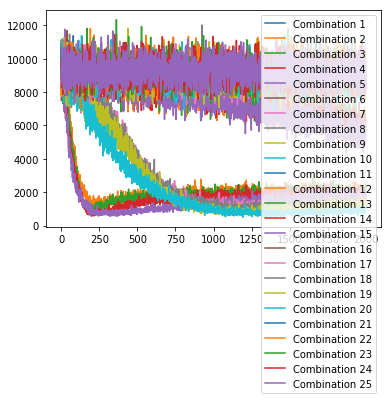

In [71]:
# x=[i for i in range(iteration)]
for i in range(len(store_err)):
    leg='Combination '+str(i+1)
    plt.plot(store_err[i,:],label=leg)
plt.legend()
plt.show()

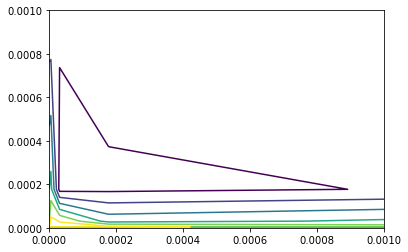

(20, 2000)

In [79]:

last_val=np.zeros([eta_1.shape[0]*eta_lmda.shape[0],1])
for i in range(new.shape[0]):
    last_val[i]=new[i][-1]
    
# print(last_val)
reshape_err=np.reshape(last_val,(eta_1.shape[0],eta_lmda.shape[0]))
plt.contour(eta_1,eta_lmda,reshape_err)
plt.show()

new.shape

In [73]:


plotly.offline.init_notebook_mode(connected=True)

# import plotly.graph_objs as go


# x = np.random.randn(2000)
# y = np.random.randn(2000)
# plotly.offline.iplot([go.Histogram2dContour(x=eta_1, y=store_err, contours=dict(coloring='heatmap')),
#        go.Scatter(x=x, y=y, mode='markers', marker=dict(color='white', size=3, opacity=0.3))], show_link=False)

trace=go.Heatmap(z=store_err)
data=[trace]

layout = go.Layout(
    title='Plot Title',
    xaxis=dict(
        title='Iteration',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Combination',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='axes-booleans')


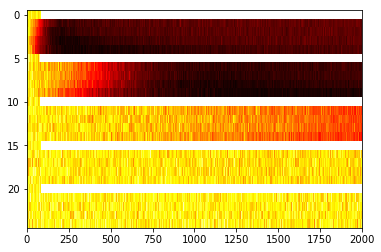

In [74]:
# store_err_a=np.array(store_err)
# len(store_err)
np.where(np.isnan(store_err)==True)
plt.imshow(store_err,cmap='hot',interpolation='nearest',aspect='auto')
plt.show()

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning:

invalid value encountered in reduce

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning:

invalid value encountered in reduce

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning:

invalid value encountered in less



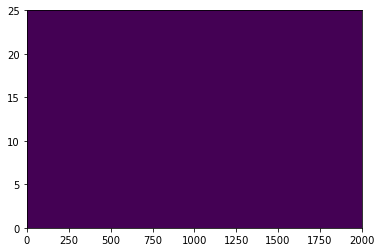

In [75]:
heatmap = plt.pcolor(store_err)
plt.show()

In [42]:
store_err[-1][-1]

9062.75

In [77]:
data=[go.Contour(z=new,x=eta_1,y=eta_lmda)]
plotly.offline.iplot(data)


(20, 2000)

In [27]:
eta_1.shape

(3,)

In [ ]:
type(uniform_data)

In [ ]:
uniform_data.shape

In [ ]:
store_err_a.shape